In [51]:
import sys
import os
from itertools import product
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
def symmetrize(A):
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B

In [8]:
all_classes = {}

all_classes["resnet"] = ['regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf',
            'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf',
            'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet18',
            'resnext50_32x4d', 'wide_resnet50_2'] # convolutional residual networks (skip connections)

all_classes["efficientnet"] = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4',
            'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7'] # convolutional

all_classes["alexnet"] = ["alexnet"] # convolutional

all_classes["googlenet"] = ["googlenet"] # convolutional

all_classes["inception"] = ["inception"] # convolutional

all_classes["mnasnet"] = ["mnasnet"] # convolutional

all_classes["densenet"] = ["densenet"] # convolutional with all-to-all skip connection (so also residual)

all_classes["shufflenet"] = ["shufflenet"] # convolutional

all_classes["squeezenet"] = ["squeezenet"] # convolutional

all_classes["vgg16"] = ["vgg16"] # convolutional

all_classes["mobilenet"] = ['mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small'] # convolutional

all_classes["convnext"] = ['convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny'] # depthwise convolutional that were designed to compete with transformers

all_classes["vit"] = ['vit_b_16', 'vit_b_32', 'vit_l_16', 'vit_l_32'] # vision transformers


classes = {}
for c in all_classes:
    if len(all_classes[c]) > 1:
        classes[c] = all_classes[c]
num_classes = len(classes)
class_names = np.array(list(classes.keys()))

In [9]:
len(classes['resnet'])

17

In [10]:
subset = "train"
n = 10000

In [20]:
pretrained_stats = np.load(f"distances/{subset}/pretrained/stats.npz")
pretrained_model_names = np.sort([x[:-4] for x in pretrained_stats["model_names"]])
num_pretrained_models = len(pretrained_model_names)

untrained_stats = np.load(f"distances/{subset}/untrained/stats.npz")
untrained_model_names = np.sort([x[:-4] for x in untrained_stats["model_names"]])
num_untrained_models = len(untrained_model_names)

In [23]:
short_untrained_model_names = np.array(["_".join(name.split("_")[:-1]) for name in untrained_model_names])
short_pretrained_model_names = np.array(["_".join(name.split("_")[:-1]) for name in pretrained_model_names])

In [24]:
distnames = np.array(['lin_cka_dist',
             'lin_cka_prime_dist',
             'mean_cca_e2e',
             'mean_sq_cca_e2e',
             'procrustes',
             'pwcca_dist_e2e',
             'predictor_dist_0.0',
             'predictor_dist_1e-20',
             'predictor_dist_1e-19',
             'predictor_dist_1e-18',
             'predictor_dist_1e-17',
             'predictor_dist_1e-16',
             'predictor_dist_1e-15',
             'predictor_dist_1e-14',
             'predictor_dist_1e-13',
             'predictor_dist_1e-12',
             'predictor_dist_1e-11',
             'predictor_dist_1e-10',
             'predictor_dist_1e-09',
             'predictor_dist_1e-08',
             'predictor_dist_1e-07',
             'predictor_dist_1e-06',
             'predictor_dist_1e-05',
             'predictor_dist_0.0001',
             'predictor_dist_0.001',
             'predictor_dist_0.01',
             'predictor_dist_0.1',
             'predictor_dist_1.0',
             'predictor_dist_10.0',
             'predictor_dist_100.0',
             'predictor_dist_1000.0',
             'predictor_dist_10000.0'])

In [13]:
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize])
#
#train_dataset = torchvision.datasets.ImageFolder("/home/gridsan/groups/datasets/ImageNet/train/", transform=transform)
#val_dataset = torchvision.datasets.ImageFolder("/home/gridsan/groups/datasets/ImageNet/val/", transform=transform)
#print(len(train_dataset))
#print(len(val_dataset))

1281119
49997


## Pretrained network embedding plot

In [32]:
distname = "predictor_dist_0.01" #"procrustes"

D = np.load(f'distances/{subset}/pretrained/{distname}.npy')
D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
D = symmetrize(D)
np.fill_diagonal(D, 0)

Z = linkage(pdist(D), 'ward')
sorted_inds = leaves_list(Z)

In [28]:
embed_type = "TSNE"

if embed_type == "TSNE":
    X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D)
elif embed_type == "UMAP":
    X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(np.sqrt(D))
elif embed_type == "MDS":
    X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(np.sqrt(D))

padding = 0.1
xmin = np.min(X_embedded[:, 0])
xmax = np.max(X_embedded[:, 0])
xrange = xmax - xmin
xmin -= padding * xrange
xmax += padding * xrange
ymin = np.min(X_embedded[:, 1])
ymax = np.max(X_embedded[:, 1])
yrange = ymax - ymin
ymin -= padding * yrange
ymax += padding * yrange

/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


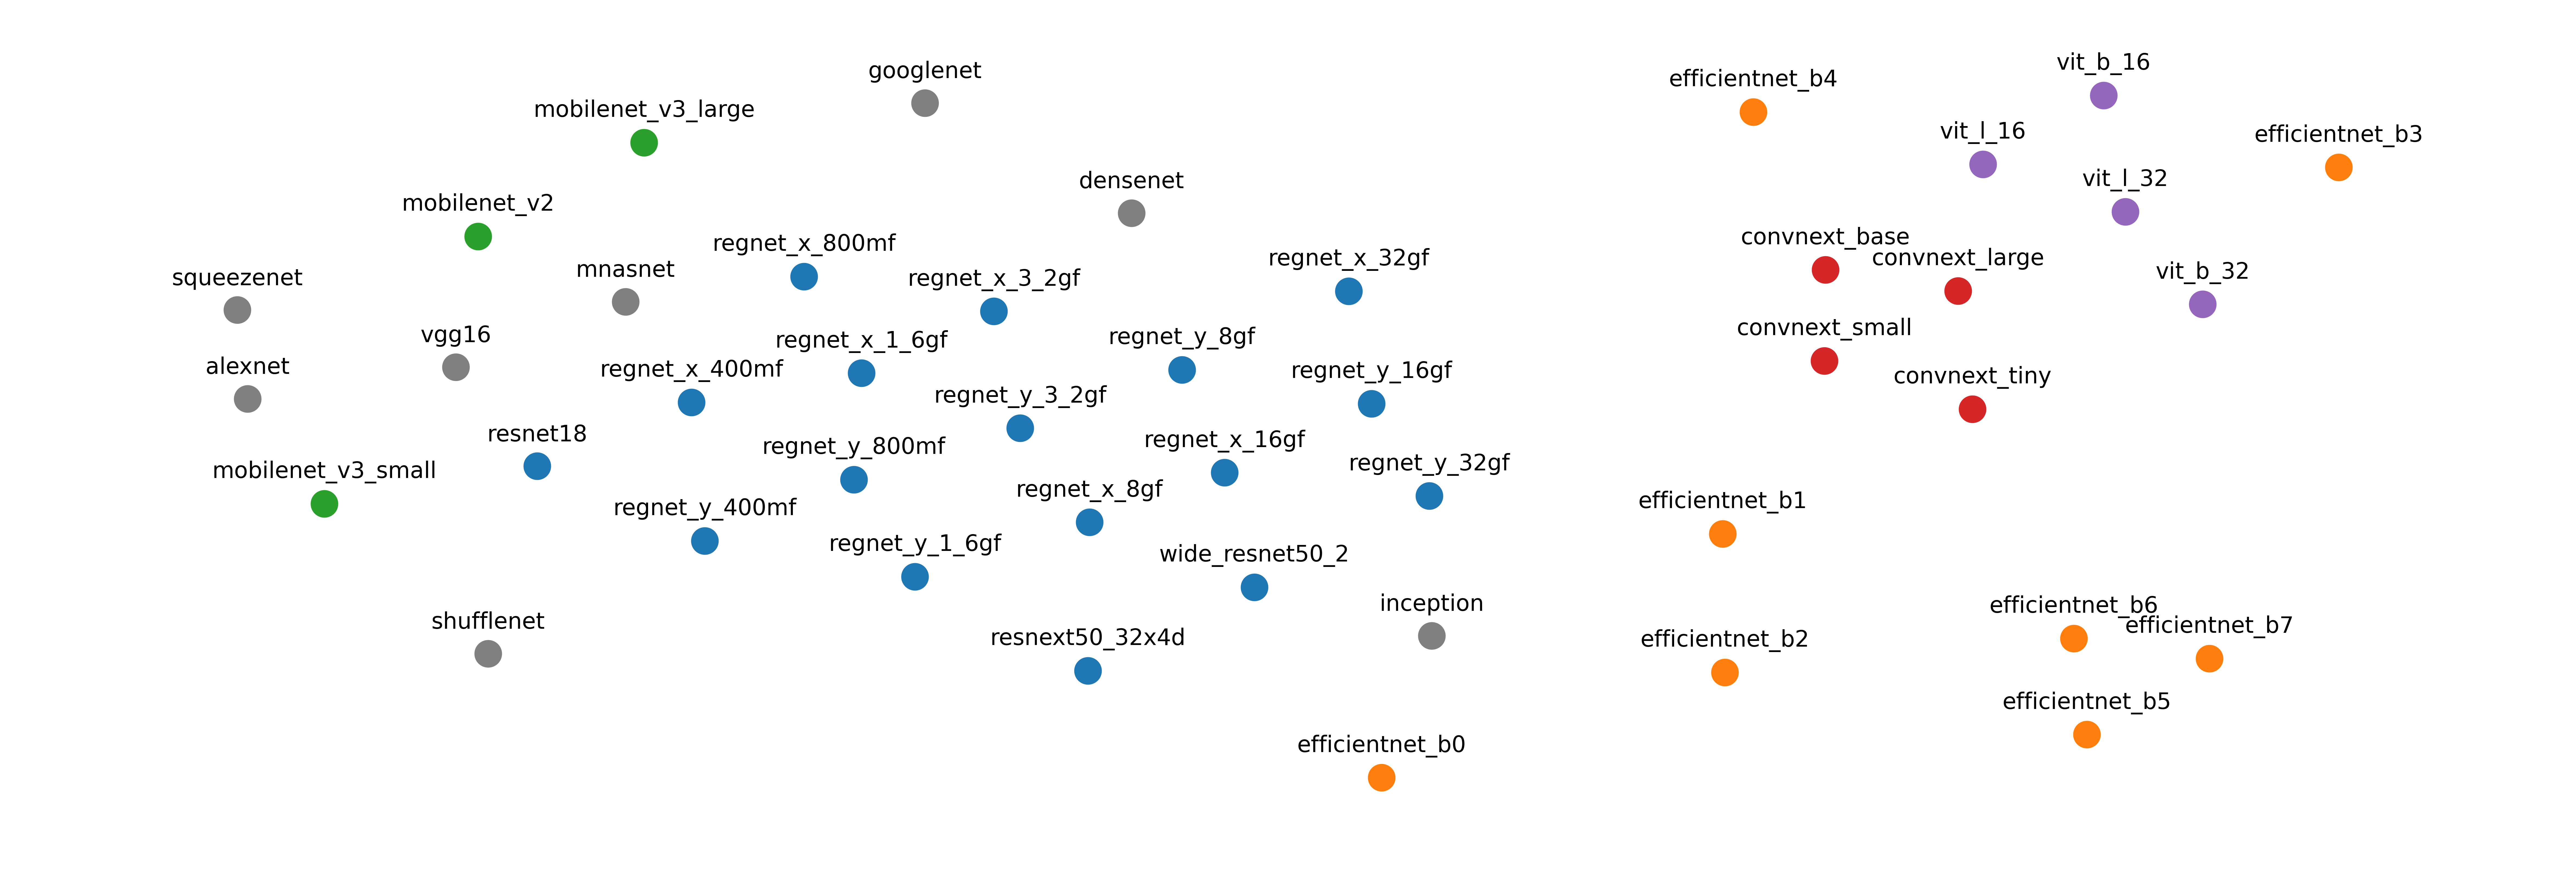

In [30]:
# plot network embedding colored by major network groups
cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig = plt.figure(dpi=1000, figsize=(12, 4))
ax = fig.add_subplot()#projection='3d')
other_inds = np.ones(len(short_pretrained_model_names), dtype=bool)
for i in range(num_classes):
    class_inds = np.in1d(short_pretrained_model_names, classes[class_names[i]])
    other_inds = other_inds & ~class_inds
    ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=40, color=colors[i])
ax.scatter(X_embedded[other_inds, 0], X_embedded[other_inds, 1], s=40, color="gray")
for i in range(num_pretrained_models):
    ax.text(X_embedded[i, 0], X_embedded[i, 1]+5, short_pretrained_model_names[i], fontsize=6, horizontalalignment="center", verticalalignment="bottom")
#plt.title(f"{embed_type} embedding for GULP λ = 1e-2")
#plt.legend(np.append(class_names, "other"))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/gulp_tsne_teaser.pdf", bbox_inches='tight')
plt.show()

## Variance ratio plots for pretrained networks

In [33]:
# take subset of untrained networks which belong to five classes (resnet, efficientnet, mobilenet, convnext, and vit)
pretrained_subset_inds = []
for j in range(num_classes):
    class_inds = np.where(np.in1d(short_pretrained_model_names, classes[class_names[j]]))[0]
    pretrained_subset_inds.append(class_inds)
pretrained_subset_inds = np.sort(np.hstack(pretrained_subset_inds))
num_pretrained_subset = len(pretrained_subset_inds)

In [35]:
# compute variance ratios for pretrained networks
num_dists = len(distnames)
pretrained_variance_ratio = np.zeros((num_dists, num_classes))
for i in range(num_dists):
    for j in range(num_classes):
        D = np.load(f'distances/{subset}/pretrained/{distnames[i]}.npy')
        D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
        D = symmetrize(D)
        np.fill_diagonal(D, 0)
        D_subset = D[pretrained_subset_inds, :][:, pretrained_subset_inds]

        class_inds = np.in1d(short_pretrained_model_names, classes[class_names[j]])
        print(class_names[j])
        print(pretrained_model_names[class_inds])
        n_class = np.sum(class_inds)
        class_variance = np.sum(D[class_inds][:, class_inds]) / (2*n_class*(n_class-1))
        total_variance = np.sum(D_subset) / (2*num_pretrained_subset*(num_pretrained_subset-1))
        pretrained_variance_ratio[i, j] = class_variance / total_variance

resnet
['regnet_x_16gf_pretrained' 'regnet_x_1_6gf_pretrained'
 'regnet_x_32gf_pretrained' 'regnet_x_3_2gf_pretrained'
 'regnet_x_400mf_pretrained' 'regnet_x_800mf_pretrained'
 'regnet_x_8gf_pretrained' 'regnet_y_16gf_pretrained'
 'regnet_y_1_6gf_pretrained' 'regnet_y_32gf_pretrained'
 'regnet_y_3_2gf_pretrained' 'regnet_y_400mf_pretrained'
 'regnet_y_800mf_pretrained' 'regnet_y_8gf_pretrained'
 'resnet18_pretrained' 'resnext50_32x4d_pretrained'
 'wide_resnet50_2_pretrained']
efficientnet
['efficientnet_b0_pretrained' 'efficientnet_b1_pretrained'
 'efficientnet_b2_pretrained' 'efficientnet_b3_pretrained'
 'efficientnet_b4_pretrained' 'efficientnet_b5_pretrained'
 'efficientnet_b6_pretrained' 'efficientnet_b7_pretrained']
mobilenet
['mobilenet_v2_pretrained' 'mobilenet_v3_large_pretrained'
 'mobilenet_v3_small_pretrained']
convnext
['convnext_base_pretrained' 'convnext_large_pretrained'
 'convnext_small_pretrained' 'convnext_tiny_pretrained']
vit
['vit_b_16_pretrained' 'vit_b_32_pretrai

In [37]:
# compute 2D embedding for pretrained networks
embed_type = "TSNE"
num_dists = len(distnames)

pretrained_embeddings = np.zeros((num_dists, num_pretrained_subset, 2))
for i in range(num_dists):
    print(f"Pretrained Networks: {distnames[i]}")
    D = np.load(f'distances/{subset}/pretrained/{distnames[i]}.npy')
    D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D_subset = D[pretrained_subset_inds, :][:, pretrained_subset_inds]
    
    if np.any(D_subset < 0):
        pretrained_embeddings[i, :, :] = np.nan
        continue

    if embed_type == "TSNE":
        X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D_subset)
    elif embed_type == "UMAP":
        X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(np.sqrt(D_subset))
    elif embed_type == "MDS":
        X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(np.sqrt(D_subset))

    pretrained_embeddings[i, :, :] = X_embedded

Pretrained Networks: lin_cka_dist


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: lin_cka_prime_dist


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: mean_cca_e2e


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: mean_sq_cca_e2e


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: procrustes


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: pwcca_dist_e2e


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.0


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-20


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-19


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-18


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-17


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-16


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-15


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-14


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-13


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-12


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-11


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-10


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-09


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-08


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-07


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-06


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-05


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.0001


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.001


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.01


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.1


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1.0


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_10.0


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_100.0


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1000.0


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_10000.0


/Users/georgestepaniants/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


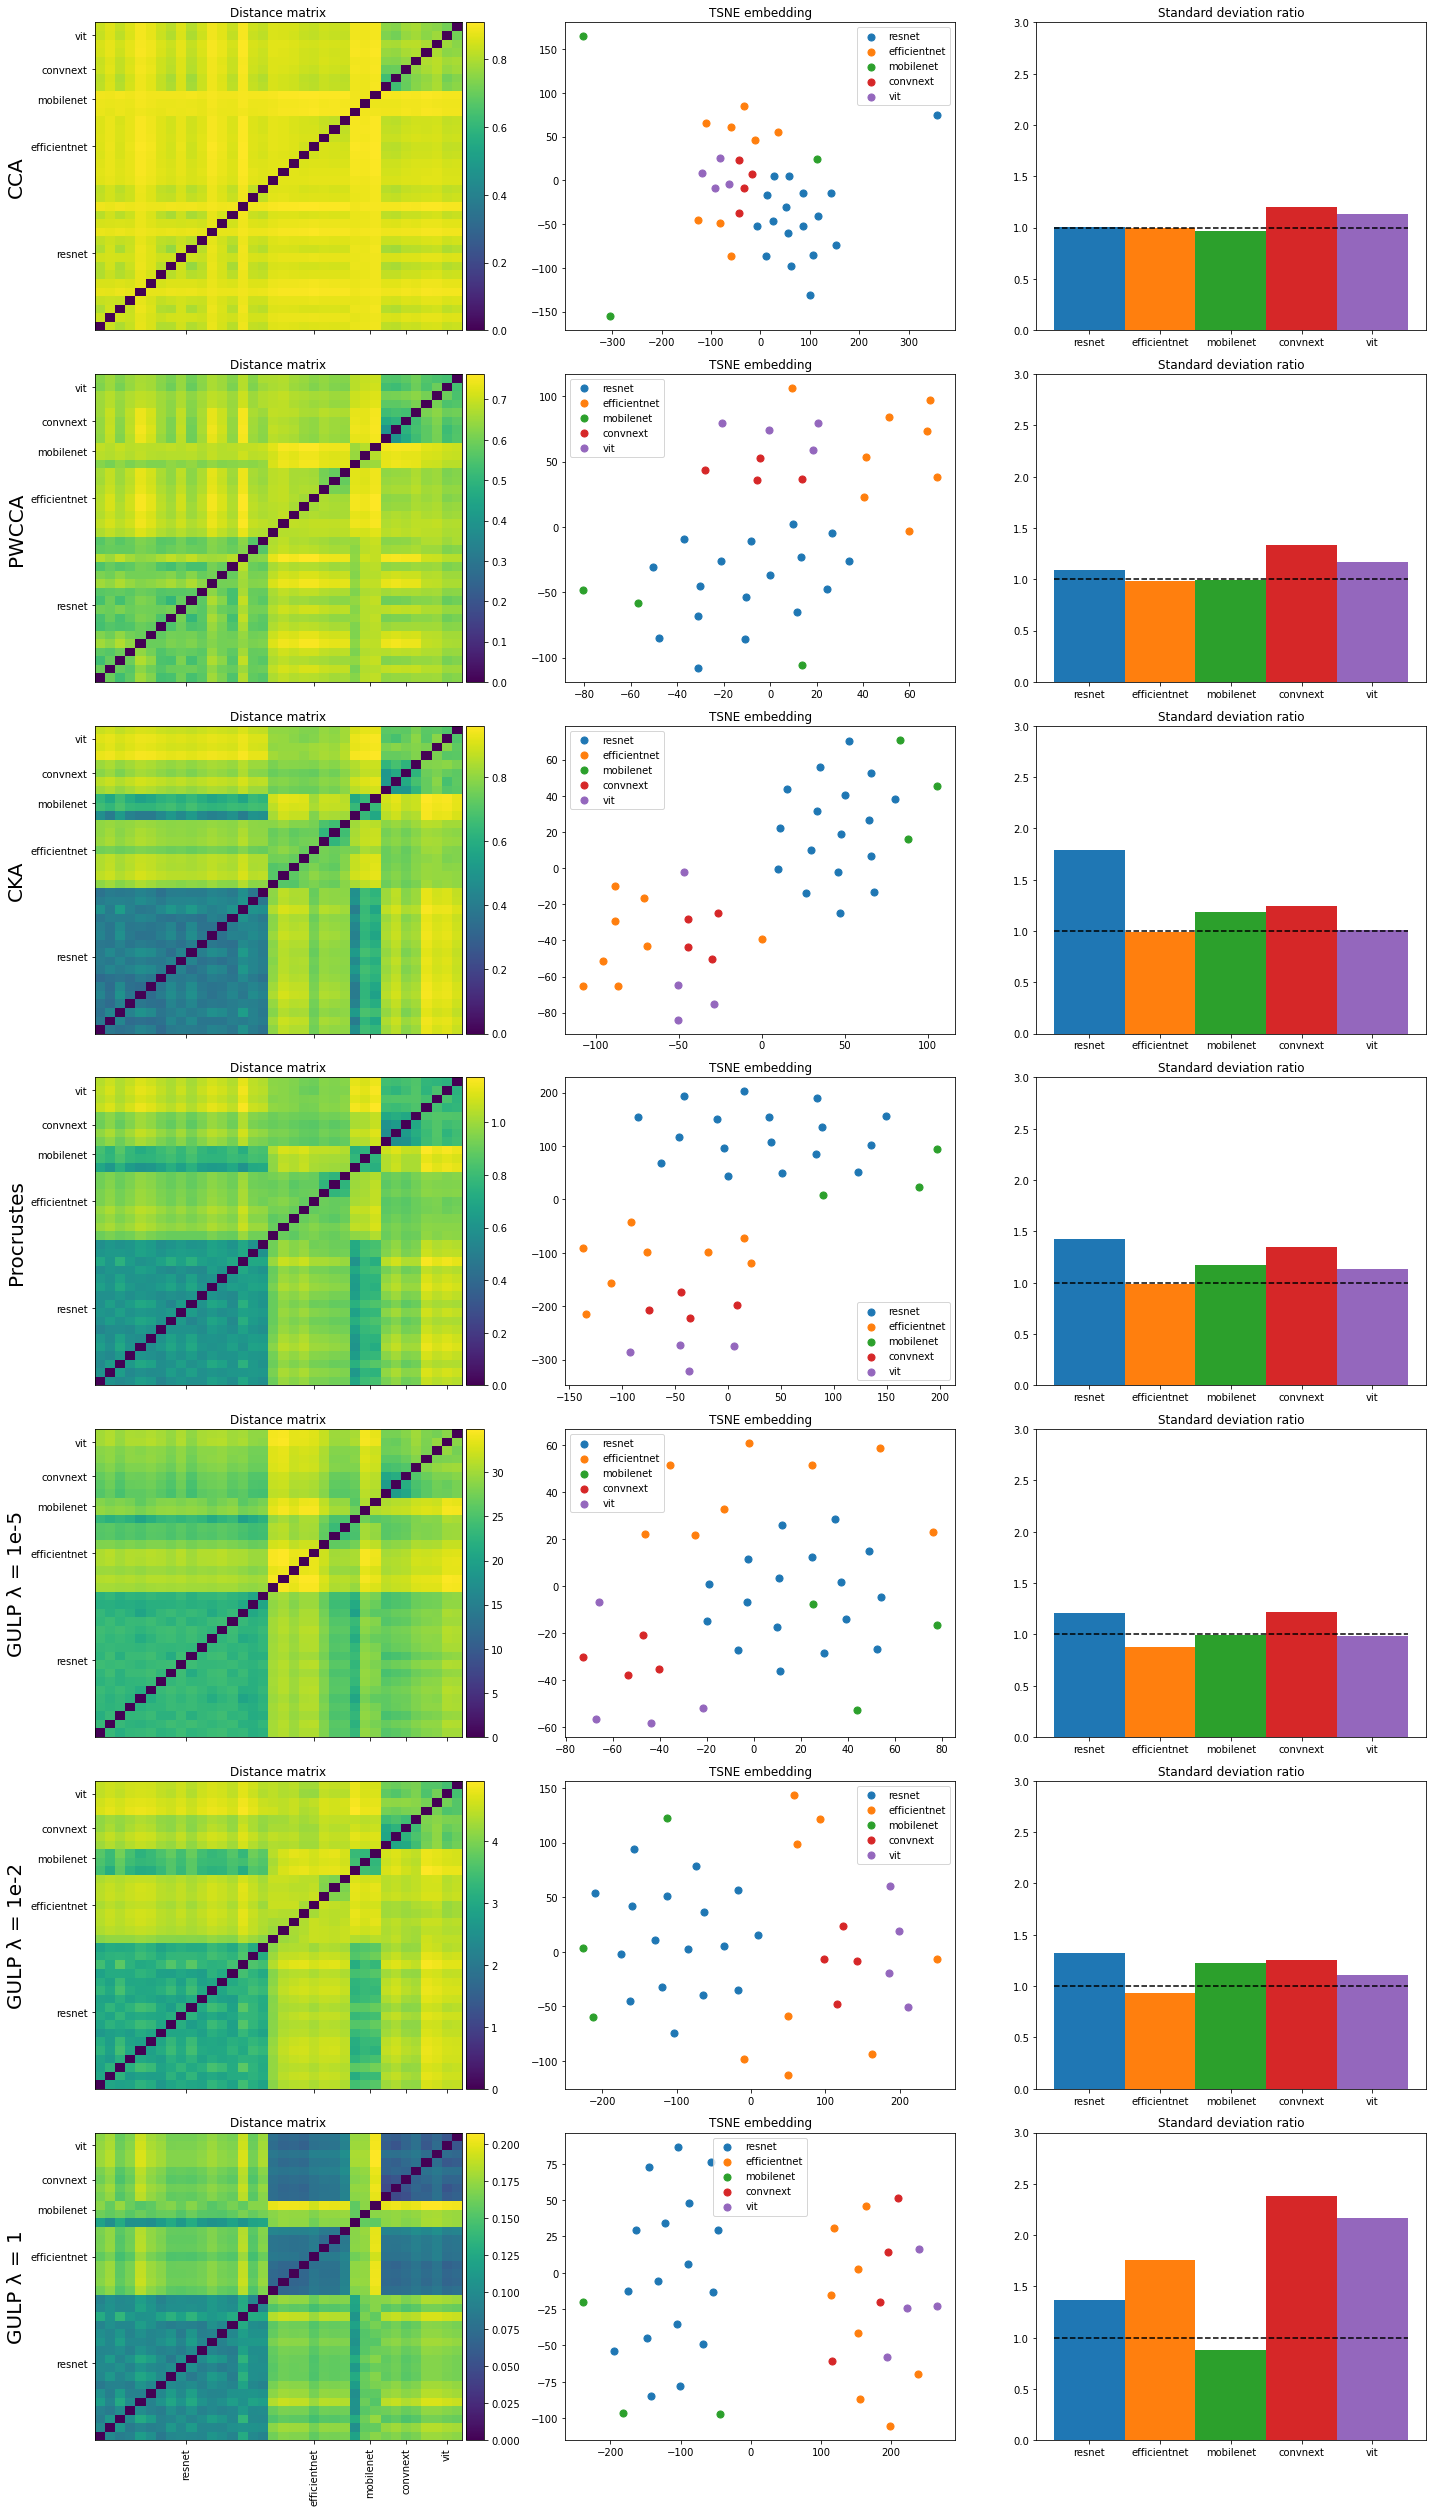

In [39]:
dist_inds = [3, 5, 0, 4, 22, 25, 27]

labels = ['CCA', 'PWCCA', 'CKA', 'Procrustes', 'GULP λ = 1e-5', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(len(dist_inds), 3, figsize=(20, 35))

sorted_inds = np.array([], dtype=int)
spacings = []
for name in class_names:
    class_inds = np.where(np.in1d(short_pretrained_model_names, classes[name]))[0]
    spacings.append(len(sorted_inds) + len(class_inds)/2)
    sorted_inds = np.append(sorted_inds, class_inds)
spacings = np.array(spacings)

for i in range(len(dist_inds)):
    D = np.load(f'distances/{subset}/pretrained/{distnames[dist_inds[i]]}.npy')
    D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    ax = axs[i, 0]
    im = ax.pcolormesh(np.sqrt(D[sorted_inds][:, sorted_inds]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title("Distance matrix")
    ax.set_yticks(spacings + 0.5)
    ax.set_yticklabels(class_names)
    ax.set_ylabel(labels[i], fontsize=20)
    ax.set_xticks(spacings + 0.5)
    if i == len(dist_inds)-1:
        ax.set_xticklabels(class_names, rotation=90)
    else:
        ax.set_xticklabels([])
    
    ax = axs[i, 1]
    X_embedded = pretrained_embeddings[dist_inds[i], :, :]
    for j in range(num_classes):
        class_inds = np.in1d(short_pretrained_model_names[pretrained_subset_inds], classes[class_names[j]])
        ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=50, color=colors[j])
    ax.set_title(f"{embed_type} embedding")
    ax.legend(class_names)
    
    ax = axs[i, 2]
    ax.bar(np.arange(num_classes), 1/np.sqrt(pretrained_variance_ratio[dist_inds[i], :]), color=colors, width = 1)
    ax.set_title("Standard deviation ratio")
    ax.set_xticks(np.arange(num_classes))
    ax.set_xticklabels(class_names)
    ax.hlines(1, -0.5, num_classes-0.5, linestyle="dashed", color="k")
    ax.set_ylim(0, 3)
fig.tight_layout()
#plt.savefig("paper_figures/imagenet_pretrained_variance_lambda.pdf")
plt.show()

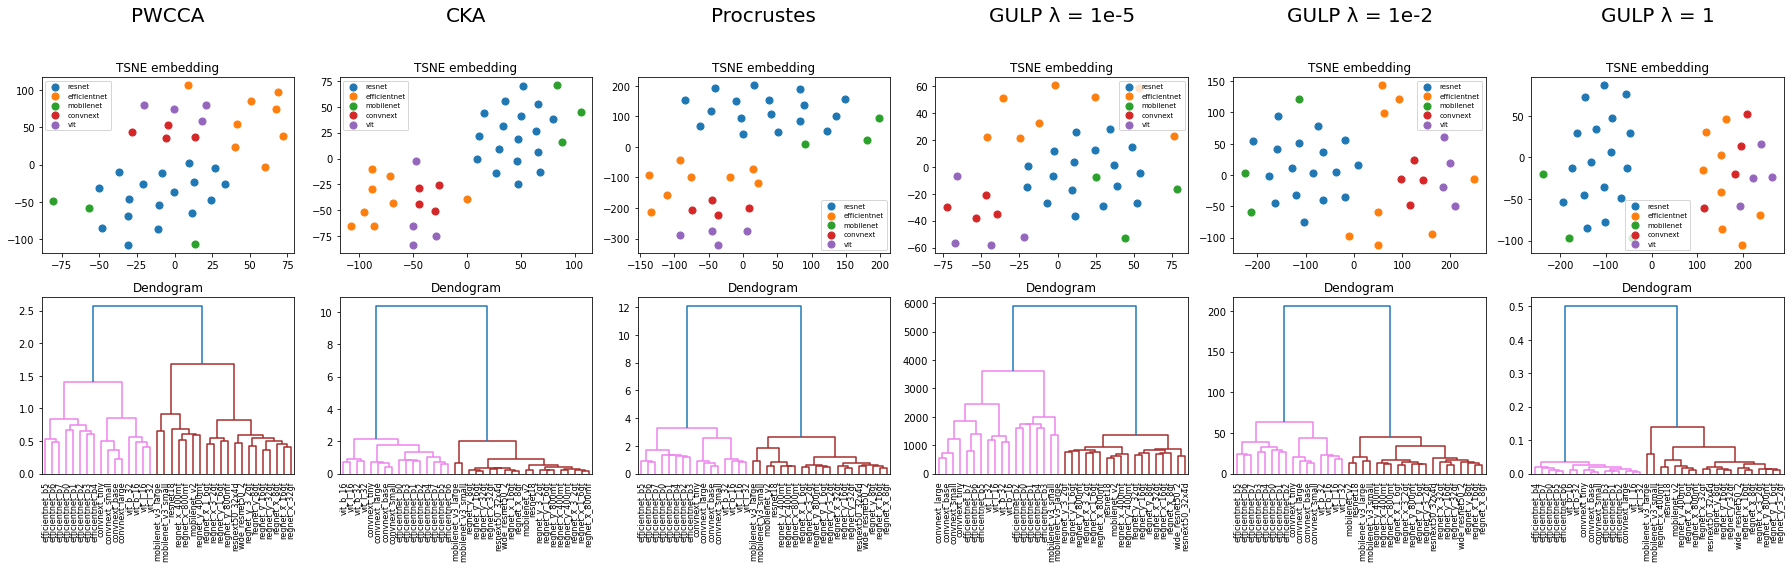

In [40]:
hierarchy.set_link_color_palette(['violet', 'brown'])

dist_inds = [5, 0, 4, 22, 25, 27] #np.arange(14, 23, 4)

labels = ['PWCCA', 'CKA', 'Procrustes', 'GULP λ = 1e-5', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(3, len(dist_inds), figsize=(25, 8), gridspec_kw={'height_ratios': [1, 30, 30]})

for i in range(len(dist_inds)):
    ax = axs[0, i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(labels[i], fontsize=20)
    
    ax = axs[1, i]
    X_embedded = pretrained_embeddings[dist_inds[i], :, :]
    for j in range(num_classes):
        class_inds = np.in1d(short_pretrained_model_names[pretrained_subset_inds], classes[class_names[j]])
        ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=50, color=colors[j])
    #for j in range(num_pretrained_models):
    #   ax.text(X_embedded[j, 0], X_embedded[j, 1], short_model_names[j], fontsize=4, horizontalalignment="center", verticalalignment="bottom")
    ax.set_title(f"{embed_type} embedding")
    ax.legend(class_names, fontsize=7)
    
    ax = axs[2, i]
    D = np.load(f'distances/{subset}/pretrained/{distnames[dist_inds[i]]}.npy')
    D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D_subset = D[pretrained_subset_inds, :][:, pretrained_subset_inds]
    Z = linkage(pdist(D_subset), 'ward')
    count_sort = 'ascending'
    if i == 3:
        count_sort = 'descending'
    dendrogram(Z, labels=short_pretrained_model_names[pretrained_subset_inds], leaf_rotation=90, count_sort=count_sort, ax=ax)
    ax.set_title("Dendogram")
fig.tight_layout()
#plt.savefig("paper_figures/imagenet_pretrained_dendogram.pdf", bbox_inches='tight')
plt.show()

## Variance ratio plots for untrained networks

In [45]:
# take subset of untrained networks which belong to four classes (resnet, efficientnet, mobilenet, convnext)
untrained_subset_inds = []
for j in range(num_classes):
    class_inds = np.where(np.in1d(short_untrained_model_names, classes[class_names[j]]))[0]
    untrained_subset_inds.append(class_inds)
untrained_subset_inds = np.sort(np.hstack(untrained_subset_inds))
num_untrained_subset = len(untrained_subset_inds)

In [46]:
# compute variance ratios for untrained networks
untrained_variance_ratio = np.zeros((num_dists, num_classes-1)) # untrained VIT networks not used
for i in range(num_dists):
    for j in range(num_classes-1):
        D = np.load(f'distances/{subset}/untrained/{distnames[i]}.npy')
        D = np.reshape(D, [num_untrained_models, num_untrained_models])
        D = symmetrize(D)
        np.fill_diagonal(D, 0)
        D_subset = D[untrained_subset_inds, :][:, untrained_subset_inds]
        
        class_inds = np.in1d(short_untrained_model_names, classes[class_names[j]])
        n_class = np.sum(class_inds)
        class_variance = np.sum(D[class_inds][:, class_inds]) / (2*n_class*(n_class-1))
        total_variance = np.sum(D_subset) / (2*num_untrained_subset*(num_untrained_subset-1))
        untrained_variance_ratio[i, j] = class_variance / total_variance

In [ ]:
# compute 2D embedding of untrained networks
untrained_embeddings = np.zeros((num_dists, num_untrained_subset, 2))
for i in range(num_dists):
    print(f"Untrained Networks: {distnames[i]}")
    D = np.load(f'distances/{subset}/untrained/{distnames[i]}.npy')
    D = np.reshape(D, [num_untrained_models, num_untrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D_subset = D[untrained_subset_inds, :][:, untrained_subset_inds]
    
    if np.any(D_subset < 0):
        untrained_embeddings[i, :, :] = np.nan
        continue
    
    if embed_type == "TSNE":
        X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D_subset)
    elif embed_type == "UMAP":
        X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(np.sqrt(D_subset))
    elif embed_type == "MDS":
        X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(np.sqrt(D_subset))

    untrained_embeddings[i, :, :] = X_embedded

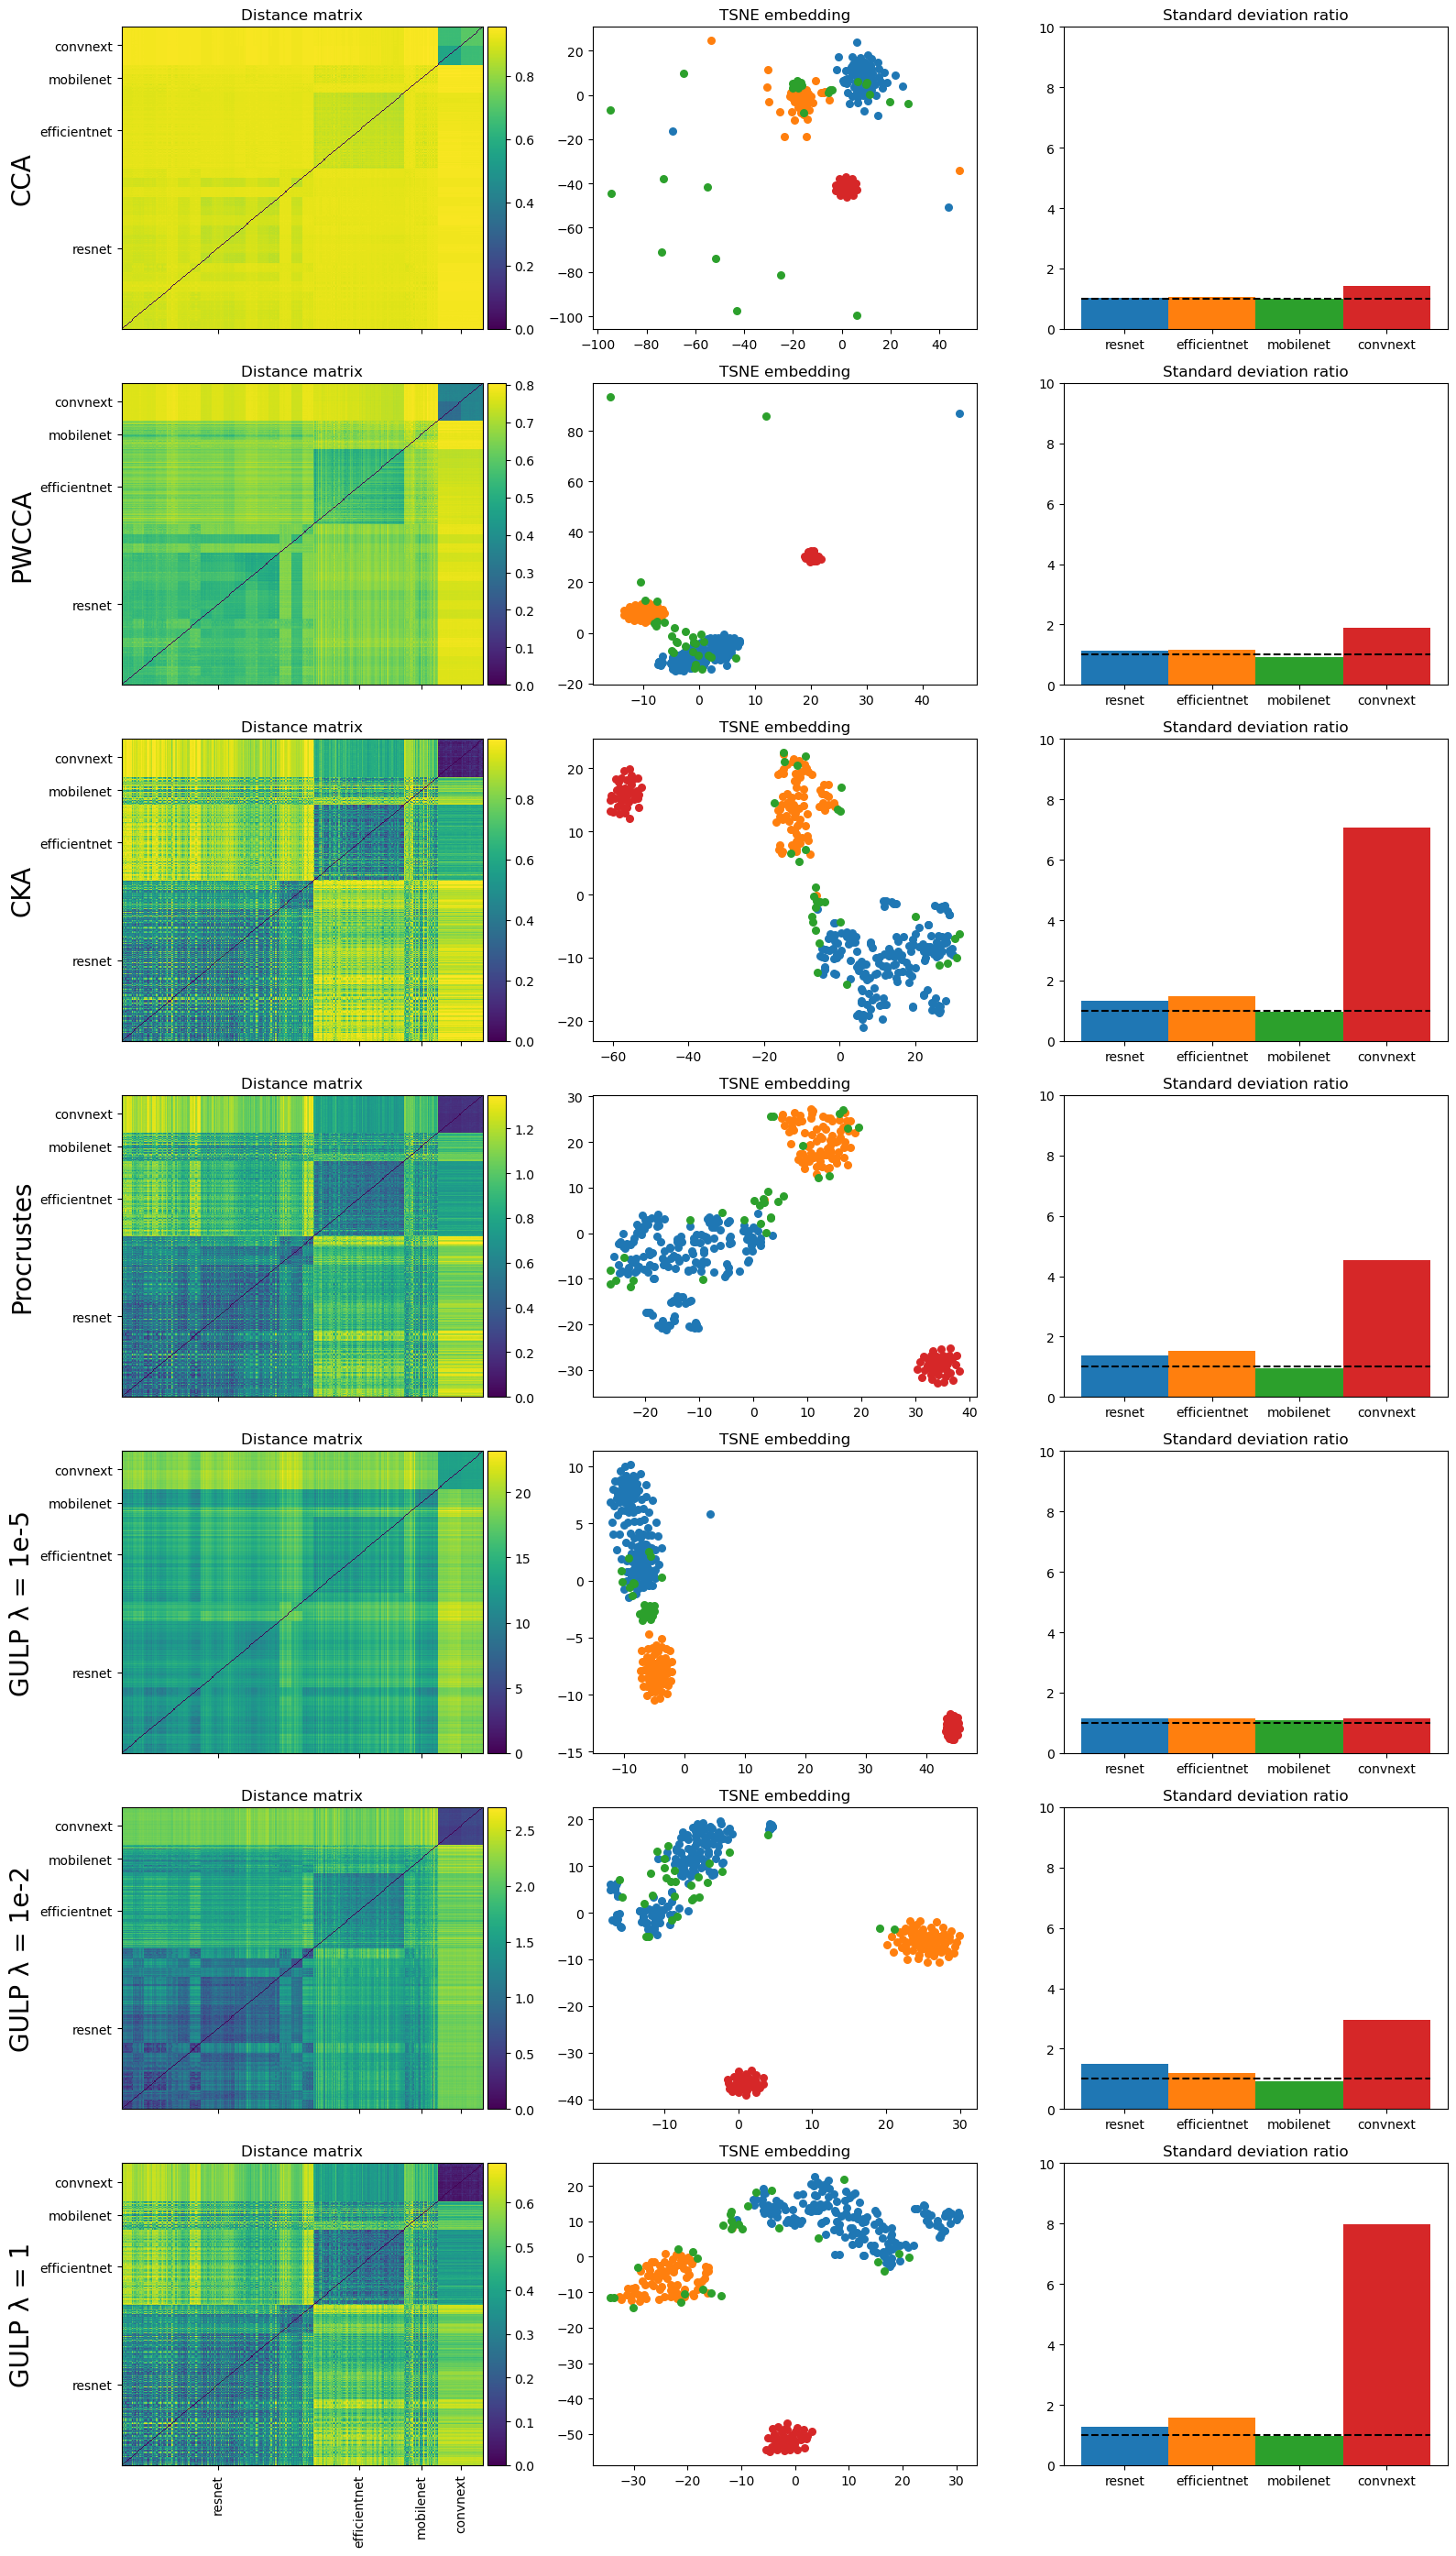

In [47]:
dist_inds = [3, 5, 0, 4, 22, 25, 27]

labels = ['CCA', 'PWCCA', 'CKA', 'Procrustes', 'GULP λ = 1e-5', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(len(dist_inds), 3, figsize=(16, 28), dpi=100)

sorted_inds = np.array([], dtype=int)
spacings = []
for name in class_names[:-1]:
    class_inds = np.where(np.in1d(short_untrained_model_names, classes[name]))[0]
    spacings.append(len(sorted_inds) + len(class_inds)/2)
    sorted_inds = np.append(sorted_inds, class_inds)
spacings = np.array(spacings)

for i in range(len(dist_inds)):
    D = np.load(f'distances/{subset}/untrained/{distnames[dist_inds[i]]}.npy')
    D = np.reshape(D, [num_untrained_models, num_untrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    ax = axs[i, 0]
    im = ax.pcolormesh(np.sqrt(D[sorted_inds][:, sorted_inds]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title("Distance matrix")
    ax.set_yticks(spacings + 0.5)
    ax.set_yticklabels(class_names[:-1])
    ax.set_ylabel(labels[i], fontsize=20)
    ax.set_xticks(spacings + 0.5)
    if i == len(dist_inds)-1:
        ax.set_xticklabels(class_names[:-1], rotation=90)
    else:
        ax.set_xticklabels([])
    
    ax = axs[i, 1]
    X_embedded = untrained_embeddings[dist_inds[i], :, :]
    for j in range(num_classes-1):
        class_inds = np.in1d(short_untrained_model_names[untrained_subset_inds], classes[class_names[j]])
        ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=30, color=colors[j])
    ax.set_title(f"{embed_type} embedding")
    
    ax = axs[i, 2]
    ax.bar(np.arange(num_classes-1), 1/np.sqrt(untrained_variance_ratio[dist_inds[i], :]), color=colors, width = 1)
    ax.set_title("Standard deviation ratio")
    ax.set_xticks(np.arange(num_classes-1))
    ax.set_xticklabels(class_names[:-1])
    ax.hlines(1, -0.5, num_classes-1-0.5, linestyle="dashed", color="k")
    ax.set_ylim(0, 10)
plt.tight_layout()
#plt.savefig("paper_figures/imagenet_untrained_variance_lambda.png")
plt.show()

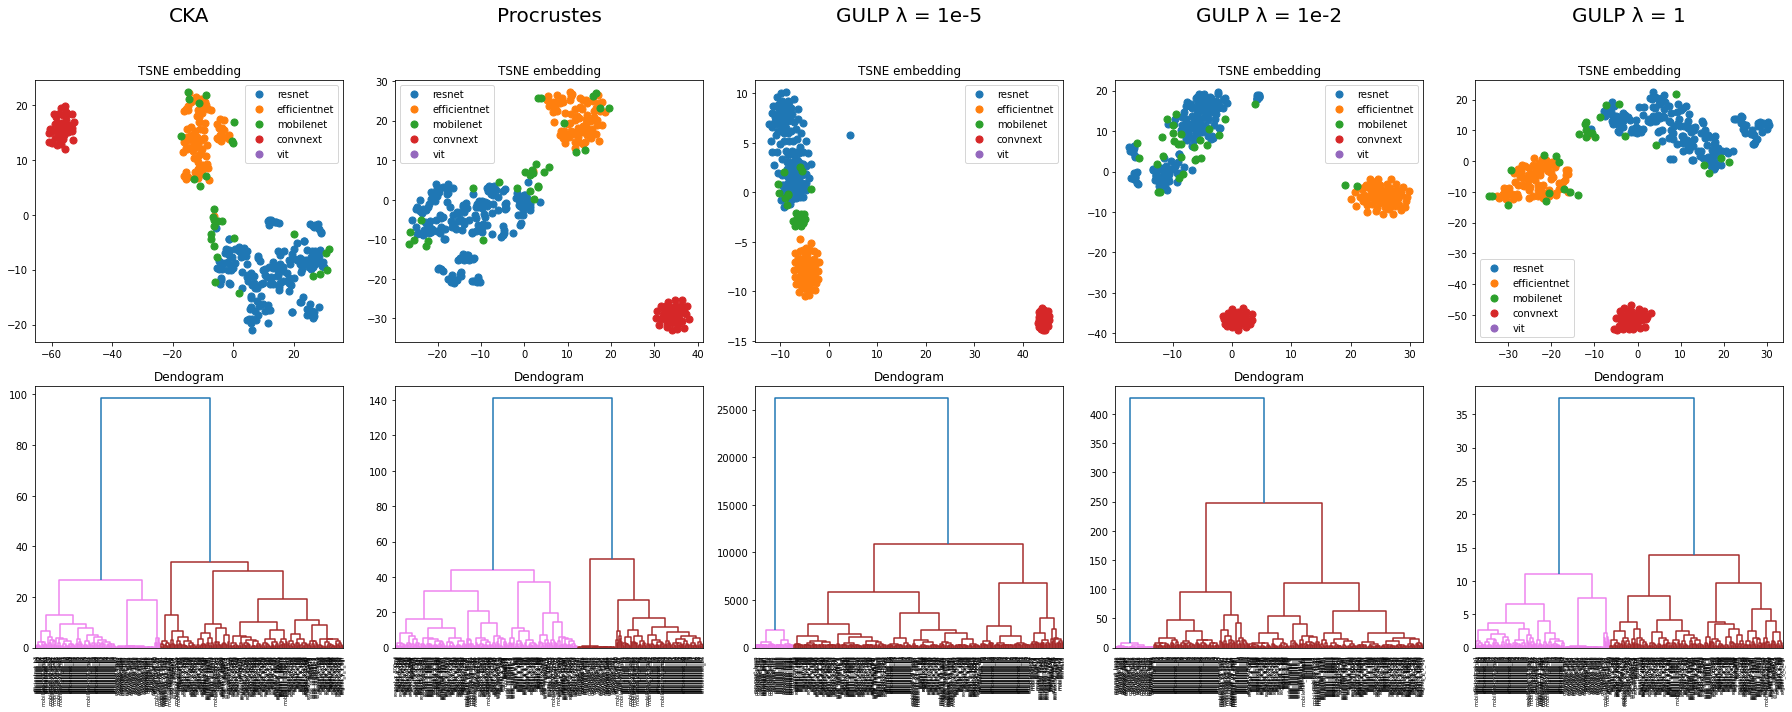

In [48]:
hierarchy.set_link_color_palette(['violet', 'brown'])

dist_inds = [0, 4, 22, 25, 27] #np.arange(14, 23, 4)

labels = ['CKA', 'Procrustes', 'GULP λ = 1e-5', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(3, len(dist_inds), figsize=(25, 10), gridspec_kw={'height_ratios': [1, 30, 30]})

for i in range(len(dist_inds)):
    ax = axs[0, i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(labels[i], fontsize=20)
    
    ax = axs[1, i]
    X_embedded = untrained_embeddings[dist_inds[i], :, :]
    for j in range(num_classes):
        class_inds = np.in1d(short_untrained_model_names[untrained_subset_inds], classes[class_names[j]])
        ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=50, color=colors[j])
    #for j in range(num_pretrained_models):
    #   ax.text(X_embedded[j, 0], X_embedded[j, 1], short_model_names[j], fontsize=4, horizontalalignment="center", verticalalignment="bottom")
    ax.set_title(f"{embed_type} embedding")
    ax.legend(class_names)
    
    ax = axs[2, i]
    D = np.load(f'distances/{subset}/untrained/{distnames[dist_inds[i]]}.npy')
    D = np.reshape(D, [num_untrained_models, num_untrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D_subset = D[untrained_subset_inds, :][:, untrained_subset_inds]
    Z = linkage(pdist(D_subset), 'ward')
    dendrogram(Z, labels=short_untrained_model_names[untrained_subset_inds], leaf_rotation=90, ax=ax)
    ax.set_title("Dendogram")
fig.tight_layout()
#plt.savefig("paper_figures/imagenet_untrained_dendogram.pdf")
plt.show()

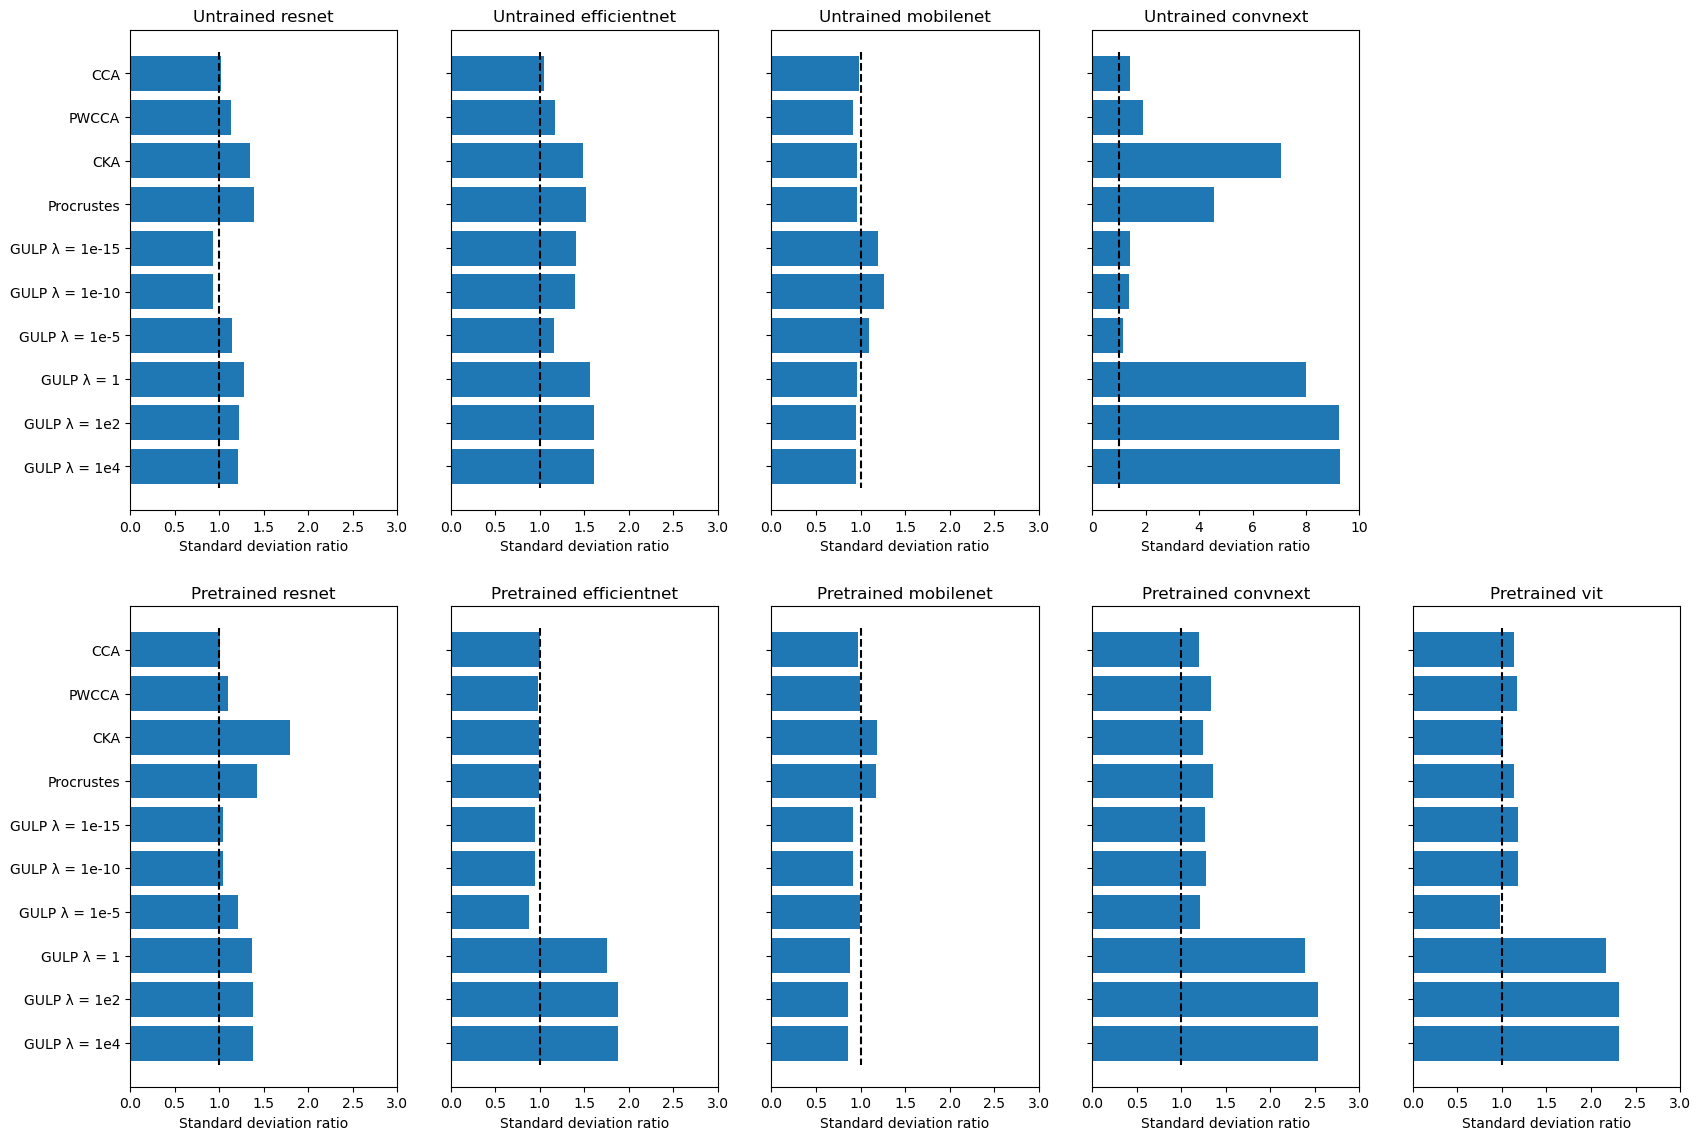

In [49]:
fig, axs = plt.subplots(2, num_classes, dpi=100, figsize=(20, 14))
fig.delaxes(axs[0, num_classes-1])

dist_inds = [3, 5, 0, 4, 12, 17, 22, 27, 29, 31]
num_dists = len(dist_inds)

labels = ['CCA', 'PWCCA', 'CKA', 'Procrustes', 'GULP λ = 1e-15', 'GULP λ = 1e-10', 'GULP λ = 1e-5', 'GULP λ = 1', 'GULP λ = 1e2', 'GULP λ = 1e4']
#labels = distnames[dist_inds]

for i in range(num_classes-1):
    ax = axs[0, i]
    ax.barh(np.arange(num_dists), 1/np.sqrt(untrained_variance_ratio[dist_inds, i]))
    ax.set_title(f"Untrained {class_names[i]}")
    ax.set_yticks(np.arange(num_dists))
    ax.vlines(1, -0.5, num_dists-0.5, linestyle="dashed", color="k")
    ax.set_xlabel("Standard deviation ratio")
    if i == 0:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])
    
    if i == num_classes-2:
        ax.set_xlim(0, 10)
    else:
        ax.set_xlim(0, 3)
    ax.invert_yaxis()

for i in range(num_classes):
    ax = axs[1, i]
    ax.barh(np.arange(num_dists), 1/np.sqrt(pretrained_variance_ratio[dist_inds, i]))
    ax.set_title(f"Pretrained {class_names[i]}")
    ax.set_yticks(np.arange(num_dists))
    if i == 0:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])
    ax.vlines(1, -0.5, num_dists-0.5, linestyle="dashed", color="k")
    ax.set_xlabel("Standard deviation ratio")
    ax.set_xlim(0, 3)
    ax.invert_yaxis()
#plt.savefig("paper_figures/imagenet_variance_networks.pdf")
plt.show()

## Distances before and after training

0, 0
0, 1
0, 2
0, 3
1, 0
1, 1
1, 2
1, 3
2, 0
2, 1
2, 2
2, 3


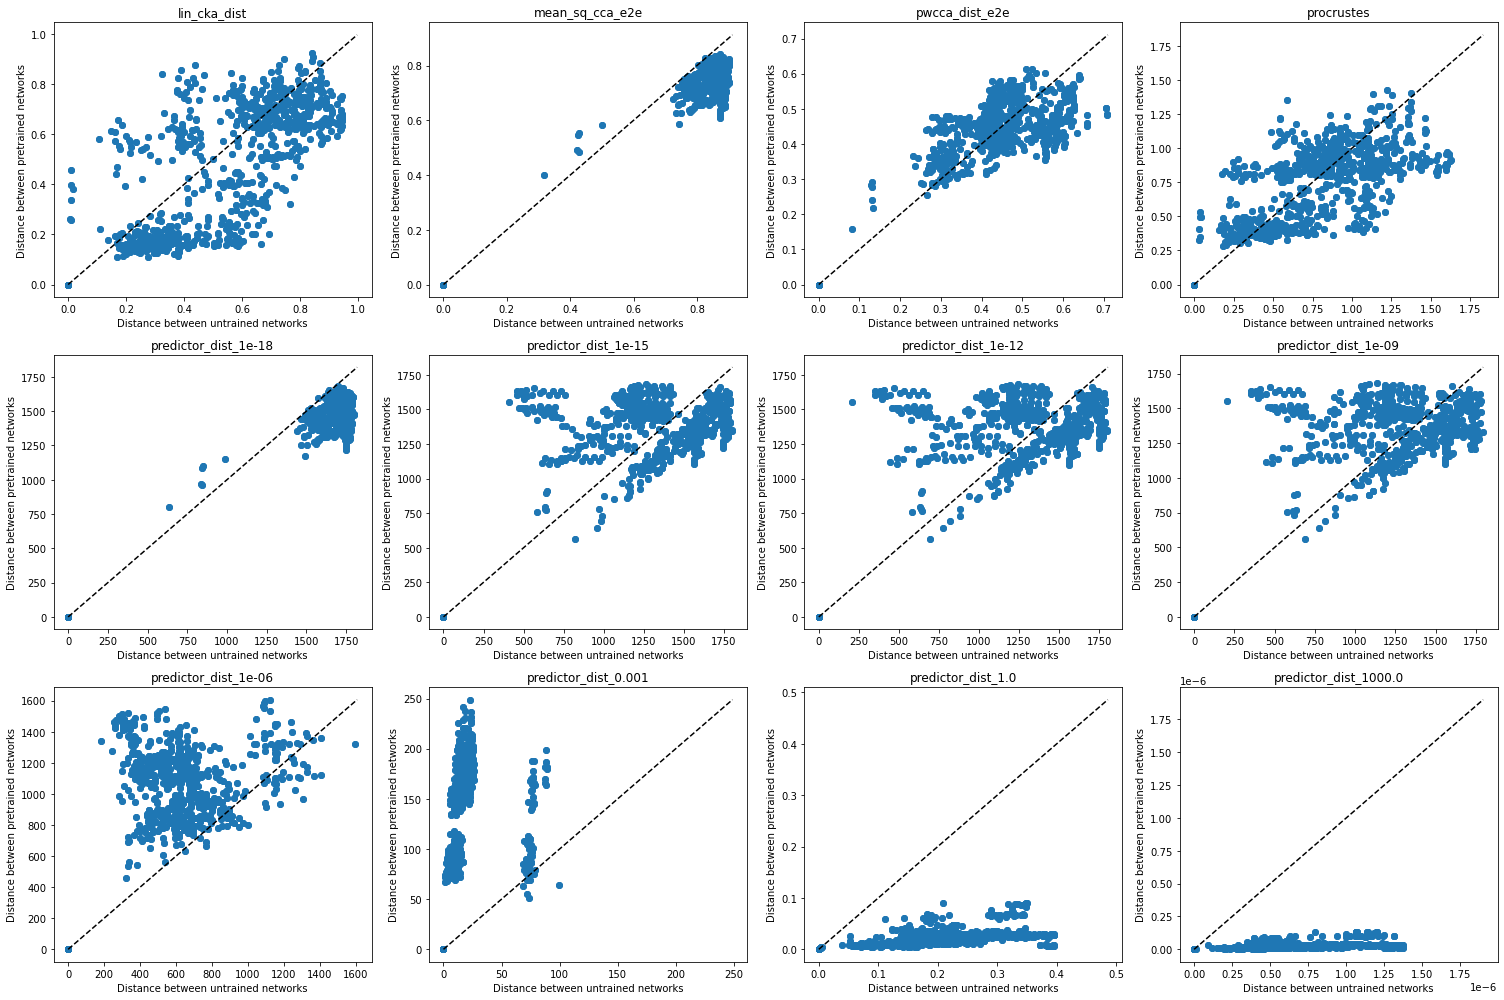

In [50]:
shared_model_names = np.sort(np.intersect1d(short_pretrained_model_names, short_untrained_model_names))
sub_inds_untrained = np.in1d(short_untrained_model_names, shared_model_names)
sub_inds_pretrained = np.in1d(short_pretrained_model_names, shared_model_names)

dist_inds = [0, 3, 5, 4, 9, 12, 15, 18, 21, 24, 27, 30]

w = 4
h = 3
fig, axs = plt.subplots(h, w, figsize=(21, 14))
for i in range(len(dist_inds)):
    D_untrained = np.load(f'distances/{subset}/untrained/{distnames[dist_inds[i]]}.npy')
    D_untrained = np.reshape(D_untrained, [num_untrained_models, num_untrained_models])
    D_untrained = symmetrize(D_untrained)
    np.fill_diagonal(D_untrained, 0)
    
    xs = []
    for j in range(10):
        xs.append(D_untrained[np.arange(j, 390, 10), :][:, np.arange(j, 390, 10)].flatten())
    xs = np.vstack(xs)
    
    D_pretrained = np.load(f'distances/{subset}/pretrained/{distnames[dist_inds[i]]}.npy')
    D_pretrained = np.reshape(D_pretrained, [num_pretrained_models, num_pretrained_models])
    D_pretrained = symmetrize(D_pretrained)
    np.fill_diagonal(D_pretrained, 0)
    D_pretrained = D_pretrained[sub_inds_pretrained][:, sub_inds_pretrained]
    y = D_pretrained.flatten()
    
    maxval = max(np.max(xs), np.max(y))
    
    print(f"{i // w}, {i % w}")
    ax = axs[i // w, i % w]
    ax.scatter(np.mean(xs, axis=0), y)
    ax.plot([0, maxval], [0, maxval], linestyle="dashed", color='k')
    ax.set_xlabel("Distance between untrained networks")
    ax.set_ylabel("Distance between pretrained networks")
    ax.set_title(f"{distnames[dist_inds[i]]}")
plt.tight_layout()
plt.show()